We will start by importing all required libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image

from PIL import JpegImagePlugin
JpegImagePlugin._getmp = lambda x: None

We can now start by importing a single real-life image

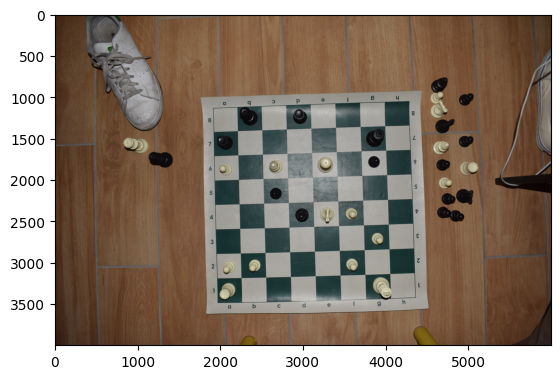

In [2]:
image = Image.open(
    "Real life data/Original/1q1r4-r5k1-P1B1Q1p1-2p5-3bNP2-6P1-PP3P2-R5K1.JPG")
image_arr = np.array(image)
plt.imshow(image_arr)

We will now proceed to define a function that converts an image's FEN notation into a vector where entry 1 represents a1, entry 2 represents a2, ..., entry 9 represents b1, ..., and entry 64 represents h8 (Column by column). Furthermore, we defined that the following convention applies to piece labels: 
- Empty: 0
- White pawn: 1
- White knight: 2
- White bishop: 3
- White rook: 4
- White queen: 5
- White king: 6
- Black pawn: 7 
- Black knight: 8
- Black bishop: 9
- Black rook: 10
- Black queen: 11
- Black king: 12

The function will basically an FEN notation string to a size 64 vector representing the position.

In [3]:
def fen_to_vector(fen):

    # The rows of the board
    board_rows_top_to_bottom = []

    # Split the fen string into rows
    # The rows are separated by either - or _
    for row in fen.replace('_', '-').split('-'):
        
        # The current row being processed
        cur_row = []

        # Go over the row elements
        for c in list(row):
            # Empty squares
            if c in '12345678':
                cur_row.extend([0] * int(c))
            # White pawn
            elif c == 'P':
                cur_row.append(1)
            # White knight
            elif c == 'N':
                cur_row.append(2)
            # White bishop
            elif c == 'B':
                cur_row.append(3)
            # White rook
            elif c == 'R':
                cur_row.append(4)
            # White queen
            elif c == 'Q':
                cur_row.append(5)
            # White king
            elif c == 'K':
                cur_row.append(6)
            # Black pawn
            elif c == 'p':
                cur_row.append(7)
            # Black knight
            elif c == 'n':
                cur_row.append(8)
            # Black bishop
            elif c == 'b':
                cur_row.append(9)
            # Black rook
            elif c == 'r':
                cur_row.append(10)
            # Black queen
            elif c == 'q':
                cur_row.append(11)
            # Black king
            elif c == 'k':
                cur_row.append(12)

        # Sanity check: The row has 8 elements
        if(len(cur_row) != 8):
            print(fen)
            print(cur_row)
        assert len(cur_row) == 8

        # Append the row
        board_rows_top_to_bottom.append(cur_row)
    
    # Convert the board to a numpy array
    board = np.array(board_rows_top_to_bottom) 

    # Transpose the board so that each row of the matrix represents a logical column
    board = board.T

    # Invert the order of each new row so that it represents the squares from bottom to top as required
    board = np.fliplr(board)

    # Flatten the rows into a single vector, from top to bottom
    vector = board.flatten()

    # Return the flattened board
    return vector

Now that we have a function to convert any FEN label to a vector as required, we can use the library defined at https://github.com/Elucidation/ChessboardDetect to crop the images to the frame of the board. Please note that we will split the training data into squares before-hand to speed up training, while testing will be done with the uncropped images in order to simulate a real-life situation.

In [4]:
%%capture

from preprocessing_utils import *

# The directory where the pre-processed data will be saved
target_dir = "./Real life data/Pre-processed/"

# The directory where the original unprocessed data is stored
original_dir = "./Real life data/Original/"

# For testing purposes
if os.path.exists(target_dir):
    shutil.rmtree(target_dir)
os.makedirs(target_dir)

# Iterate over the real life images
for i, filename in enumerate(os.listdir(original_dir)):

    # Remove the .JPG extension to get the FEN noation
    fen = filename.split('.')[0] 

    # Convert the FEN notation to a vector
    vector = fen_to_vector(fen)

    # Extract the squares by warping the image and cropping it
    warped_image = warp_image(original_dir + filename)
    squares = crop_individual_squares(warped_image)

    # Create the array that will be used to store the position
    final_array = np.array(["Square name", "Image", "Piece label"], dtype=object)

    # Represent the whole position as a single numpy array
    for j in range(64):
        square_name = j+1 # Since a1 represents 1
        square_image = squares[j]
        piece_label = vector[j]
        final_array = np.vstack((final_array, [square_name, square_image, piece_label]))
    
    # Save the array
    example_name = "EX_%04d" % i
    np.save(target_dir + example_name, final_array, allow_pickle=True)


We can now visualize square 49 from example 9 as follows:

Text(0.5, 1.0, 'Square 49 of position 0009 with label 6')

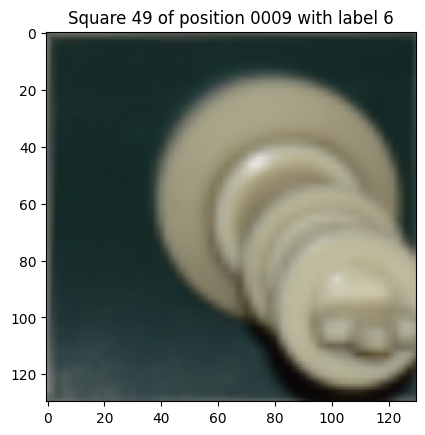

In [5]:
array = np.load("Real life data/Pre-processed/EX_0009.npy", allow_pickle=True)
plt.imshow(array[49][1])
plt.title("Square 49 of position 0009 with label " + str(array[49][2]))
